# Wind energy production prediction

## Importing packages 

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, SimpleRNN
import matplotlib.pyplot as plt


## Loading the data

In [8]:
df = pd.read_csv('../data/Model/production_wind_data.csv')
df

,datetime,point,type,granularity,timezone,activity,classification,capacity,volume,percentage,...,CloudCover,RelativeAtmosphericHumidity,IndicatorWeatherCode,Fog,Rain,Snow,Thunder,IceFormation,AvgDailyTemperature,TemperatureAvgMonthlyTemperature
0,2021-01-01 00:00:00,Nederland,Wind,Hour,UTC,Providing,Current,95906,95906,0.026977,...,0,98,7,1,0,0,0,1,2.970833,3.376747
1,2021-01-01 01:00:00,Nederland,Wind,Hour,UTC,Providing,Current,122117,122117,0.034349,...,1,98,7,1,0,0,0,1,2.970833,3.376747
2,2021-01-01 02:00:00,Nederland,Wind,Hour,UTC,Providing,Current,87353,87353,0.024571,...,7,98,7,1,0,0,0,1,2.970833,3.376747
3,2021-01-01 03:00:00,Nederland,Wind,Hour,UTC,Providing,Current,59687,59687,0.016788,...,8,98,7,1,0,0,0,1,2.970833,3.376747
4,2021-01-01 04:00:00,Nederland,Wind,Hour,UTC,Providing,Current,53359,53359,0.015008,...,8,95,7,0,0,0,0,0,2.970833,3.376747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52553,2023-12-31 18:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,3144000,3144000,1.431400,...,8,78,7,0,1,0,0,0,8.829167,6.888441
52554,2023-12-31 19:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,3102250,3102250,1.412392,...,8,77,7,0,1,0,0,0,8.829167,6.888441
52555,2023-12-31 20:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,3086249,3086249,1.405107,...,8,84,7,0,1,0,0,0,8.829167,6.888441
52556,2023-12-31 21:00:00,Nederland,WindOffshoreC,Hour,UTC,Providing,Current,3051749,3051749,1.389403,...,8,84,7,0,1,0,0,0,8.829167,6.888441


## Feature selection

In [9]:
# Convert 'datetime' to datetime format and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Features and target selection
features = ['WindSpeedAvg60min', 'Temperature', 'Pressure', 'RelativeAtmosphericHumidity']
target = 'capacity'


In [10]:
# Scale the data
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit and transform features and target
scaled_features = feature_scaler.fit_transform(df[features])
scaled_target = target_scaler.fit_transform(df[[target]])

# Combine scaled features and target
scaled_data = np.hstack([scaled_features, scaled_target])


In [11]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length, :-1]
        y = data[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length
seq_length = 24  # Use past 24 hours to predict the next hour

# Create sequences
X, y = create_sequences(scaled_data, seq_length)


In [12]:
# Split the data into training and testing sets
from sklearn.utils import shuffle

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)

# Split the shuffled dataset
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]



## Modeling

To start the modeling section, it has been decided to first test different models and then improve on the models with the most potential.

To start off with LSTM. LSTM stands for Long Short-Term Memory. It is a deep learning model that is comparable to an ARIMA model. While ARIMA is not suited for long-term predictions beyond 6 months, LSTM is more suited for these types of time series predictions.

In [13]:
# Build the LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    LSTM(256),
    Dropout(0.2),
    Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2)

Epoch 1/30
1051/1051 - 21s - 20ms/step - loss: 0.0199 - mae: 0.1033 - val_loss: 0.0183 - val_mae: 0.1001
Epoch 2/30
1051/1051 - 19s - 18ms/step - loss: 0.0181 - mae: 0.0987 - val_loss: 0.0186 - val_mae: 0.0961
Epoch 3/30
1051/1051 - 19s - 18ms/step - loss: 0.0171 - mae: 0.0954 - val_loss: 0.0169 - val_mae: 0.0934
Epoch 4/30
1051/1051 - 19s - 18ms/step - loss: 0.0167 - mae: 0.0939 - val_loss: 0.0165 - val_mae: 0.0920
Epoch 5/30
1051/1051 - 18s - 17ms/step - loss: 0.0164 - mae: 0.0929 - val_loss: 0.0164 - val_mae: 0.0918
Epoch 6/30
1051/1051 - 17s - 16ms/step - loss: 0.0163 - mae: 0.0921 - val_loss: 0.0164 - val_mae: 0.0923
Epoch 7/30
1051/1051 - 17s - 16ms/step - loss: 0.0161 - mae: 0.0920 - val_loss: 0.0165 - val_mae: 0.0905
Epoch 8/30
1051/1051 - 16s - 15ms/step - loss: 0.0161 - mae: 0.0918 - val_loss: 0.0166 - val_mae: 0.0954
Epoch 9/30
1051/1051 - 16s - 16ms/step - loss: 0.0160 - mae: 0.0914 - val_loss: 0.0165 - val_mae: 0.0903
Epoch 10/30
1051/1051 - 17s - 16ms/step - loss: 0.0159 

In [15]:
# Make predictions
predictions = model.predict(X_test)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [16]:
# Inverse transform predictions and actual values
predicted_capacity = target_scaler.inverse_transform(predictions)
actual_capacity = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()


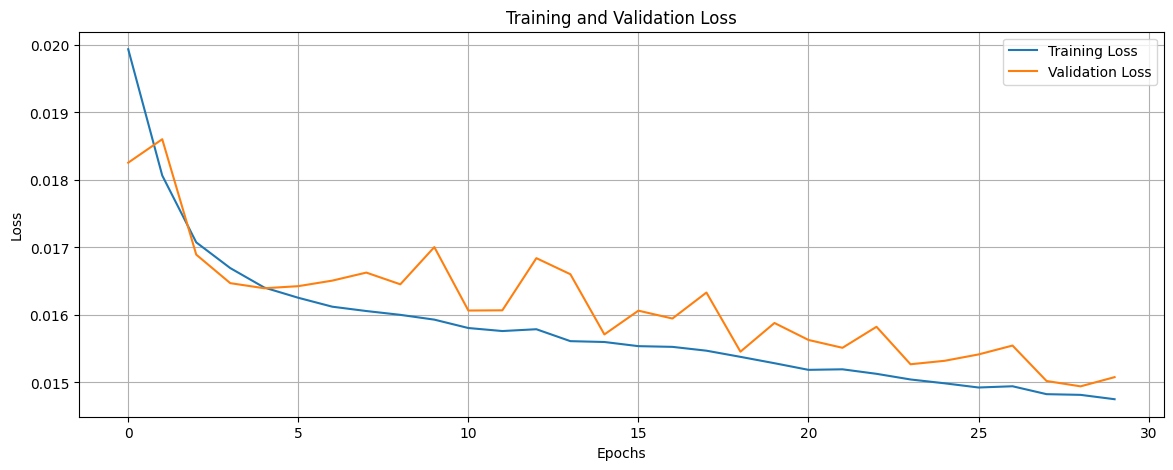

In [17]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


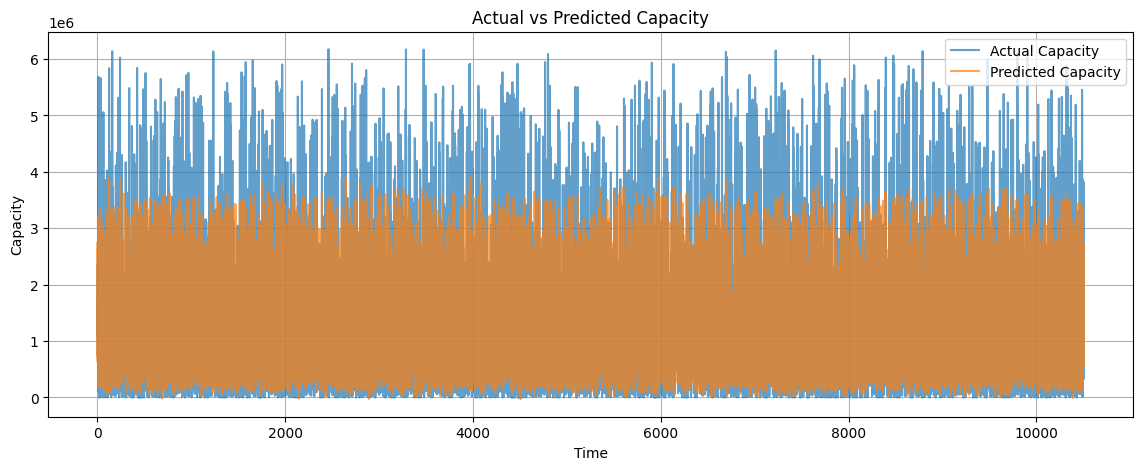

In [18]:
# Plot Predictions vs Actual Values
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_capacity, label='Predicted Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

### RNN

In [19]:
# Build the RNN model
rnn_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(256),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 24, 128)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 256)            │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,841 (452.50 KB)

 Trainable params: 115,841 (452.50 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the RNN model
rnn_history = rnn_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)


Epoch 1/30
1051/1051 - 5s - 5ms/step - loss: 0.0497 - mae: 0.1543 - val_loss: 0.0192 - val_mae: 0.0982
Epoch 2/30
1051/1051 - 4s - 4ms/step - loss: 0.0211 - mae: 0.1079 - val_loss: 0.0210 - val_mae: 0.1055
Epoch 3/30
1051/1051 - 4s - 4ms/step - loss: 0.0192 - mae: 0.1021 - val_loss: 0.0179 - val_mae: 0.0952
Epoch 4/30
1051/1051 - 4s - 4ms/step - loss: 0.0179 - mae: 0.0981 - val_loss: 0.0184 - val_mae: 0.0959
Epoch 5/30
1051/1051 - 4s - 4ms/step - loss: 0.0174 - mae: 0.0963 - val_loss: 0.0170 - val_mae: 0.0935
Epoch 6/30
1051/1051 - 4s - 4ms/step - loss: 0.0173 - mae: 0.0958 - val_loss: 0.0174 - val_mae: 0.0927
Epoch 7/30
1051/1051 - 4s - 4ms/step - loss: 0.0172 - mae: 0.0952 - val_loss: 0.0178 - val_mae: 0.0935
Epoch 8/30
1051/1051 - 4s - 4ms/step - loss: 0.0171 - mae: 0.0950 - val_loss: 0.0174 - val_mae: 0.0944
Epoch 9/30
1051/1051 - 4s - 4ms/step - loss: 0.0171 - mae: 0.0949 - val_loss: 0.0174 - val_mae: 0.0927
Epoch 10/30
1051/1051 - 4s - 4ms/step - loss: 0.0171 - mae: 0.0953 - val_

In [21]:
# Make predictions using the RNN model
rnn_predictions = rnn_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn_capacity = target_scaler.inverse_transform(rnn_predictions)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


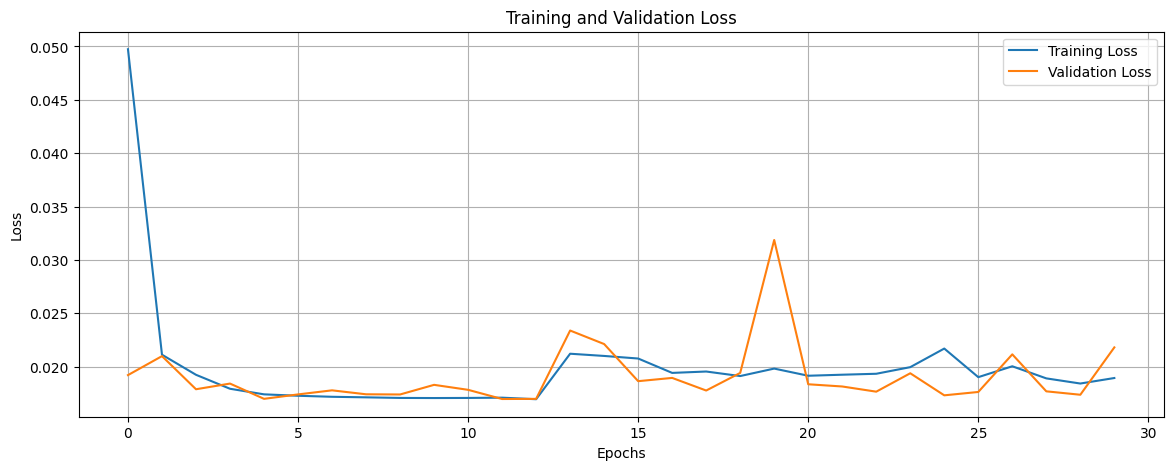

In [22]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn_history.history['loss'], label='Training Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

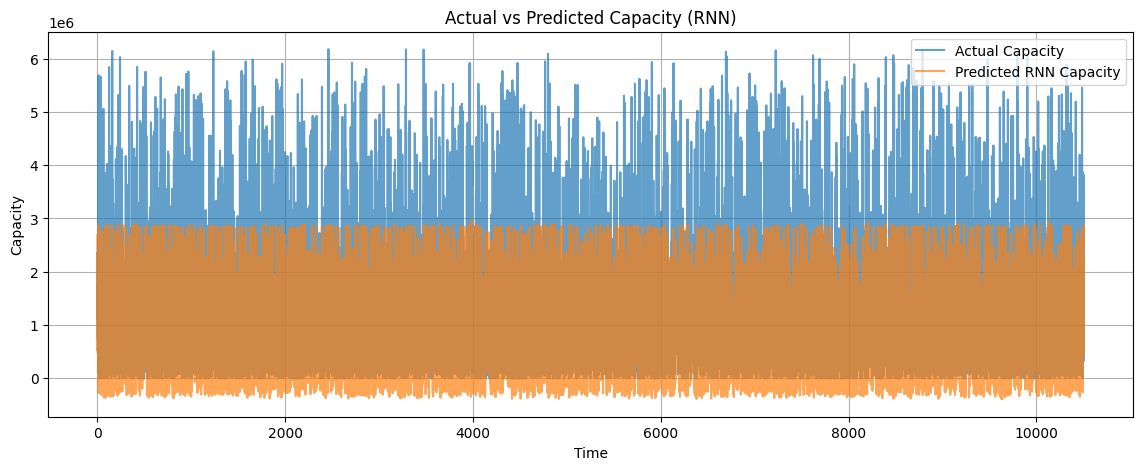

In [23]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()


### comparison plot

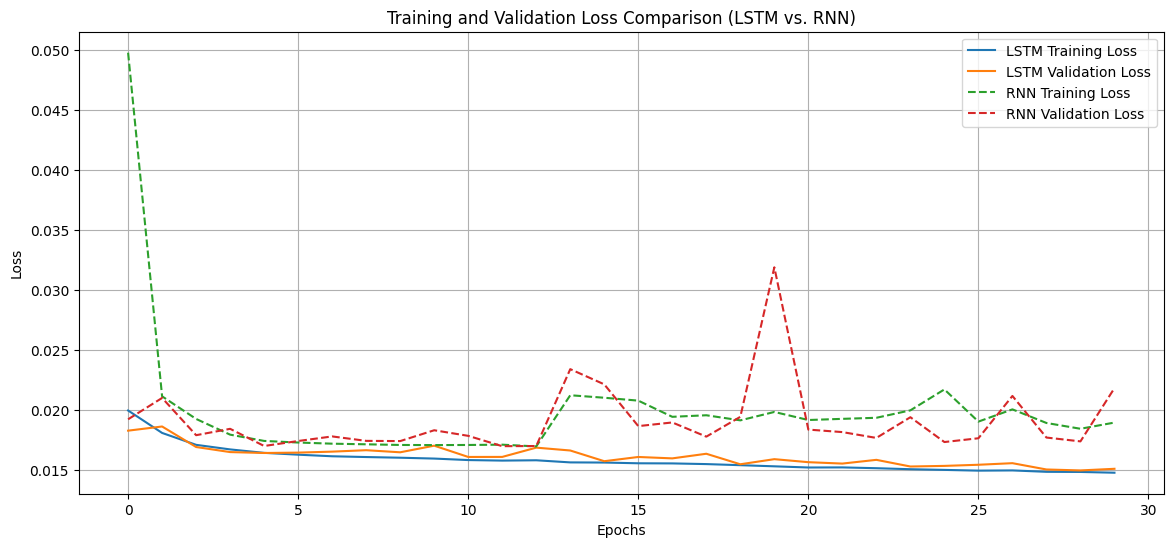

In [24]:
# Plot training and validation loss for both LSTM and RNN
plt.figure(figsize=(14, 6))

# LSTM Loss
plt.plot(history.history['loss'], label='LSTM Training Loss')
plt.plot(history.history['val_loss'], label='LSTM Validation Loss')

# RNN Loss
plt.plot(rnn_history.history['loss'], label='RNN Training Loss', linestyle='dashed')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss', linestyle='dashed')

# Titles and labels
plt.title('Training and Validation Loss Comparison (LSTM vs. RNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


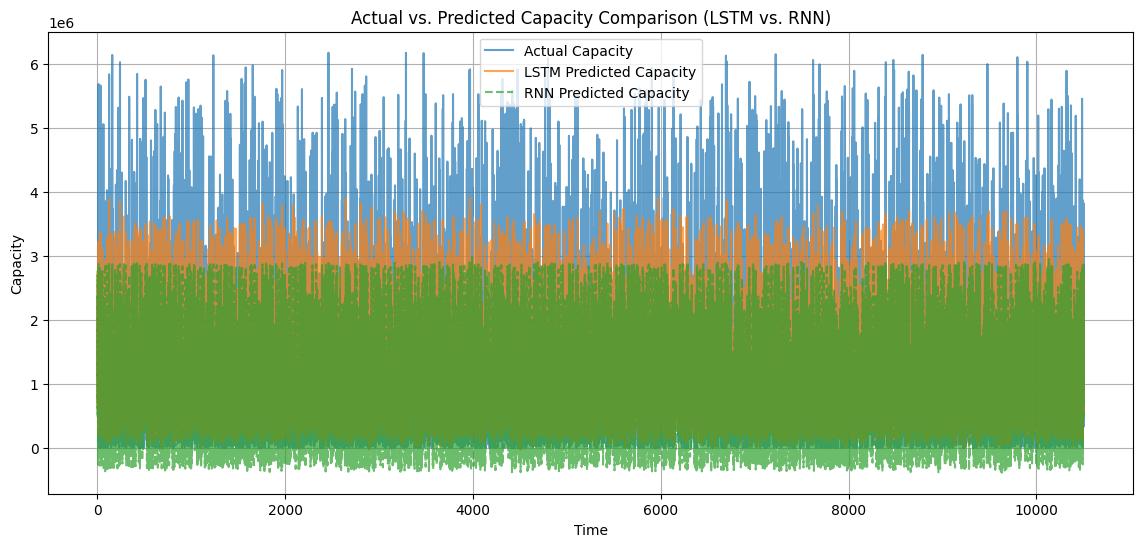

In [25]:
# Plot Actual vs. Predicted Capacity for both LSTM and RNN
plt.figure(figsize=(14, 6))

# Actual values
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)

# LSTM Predictions
plt.plot(predicted_capacity, label='LSTM Predicted Capacity', alpha=0.7)

# RNN Predictions
plt.plot(predicted_rnn_capacity, label='RNN Predicted Capacity', alpha=0.7, linestyle='dashed')

# Titles and labels
plt.title('Actual vs. Predicted Capacity Comparison (LSTM vs. RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()


### GRU

In [26]:
from tensorflow.keras.layers import GRU

GRU_model = Sequential([
    GRU(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    GRU(64),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
GRU_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
GRU_model.summary()

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 24, 128)        │        51,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,769 (346.75 KB)

 Trainable params: 88,769 (346.75 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Train the RNN model
GRU_history = GRU_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)


Epoch 1/30
1051/1051 - 8s - 7ms/step - loss: 0.0200 - mae: 0.1032 - val_loss: 0.0185 - val_mae: 0.0959
Epoch 2/30
1051/1051 - 7s - 6ms/step - loss: 0.0183 - mae: 0.0988 - val_loss: 0.0176 - val_mae: 0.0960
Epoch 3/30
1051/1051 - 7s - 6ms/step - loss: 0.0175 - mae: 0.0967 - val_loss: 0.0176 - val_mae: 0.0933
Epoch 4/30
1051/1051 - 6s - 6ms/step - loss: 0.0168 - mae: 0.0942 - val_loss: 0.0166 - val_mae: 0.0932
Epoch 5/30
1051/1051 - 6s - 6ms/step - loss: 0.0165 - mae: 0.0932 - val_loss: 0.0169 - val_mae: 0.0934
Epoch 6/30
1051/1051 - 6s - 6ms/step - loss: 0.0165 - mae: 0.0930 - val_loss: 0.0164 - val_mae: 0.0912
Epoch 7/30
1051/1051 - 7s - 6ms/step - loss: 0.0163 - mae: 0.0927 - val_loss: 0.0165 - val_mae: 0.0955
Epoch 8/30
1051/1051 - 6s - 6ms/step - loss: 0.0162 - mae: 0.0924 - val_loss: 0.0162 - val_mae: 0.0912
Epoch 9/30
1051/1051 - 7s - 6ms/step - loss: 0.0160 - mae: 0.0919 - val_loss: 0.0165 - val_mae: 0.0931
Epoch 10/30
1051/1051 - 7s - 6ms/step - loss: 0.0161 - mae: 0.0919 - val_

In [28]:
# Make predictions using the RNN model
GRU_predictions = GRU_model.predict(X_test)

# Inverse transform the predictions
predicted_GRU_capacity = target_scaler.inverse_transform(GRU_predictions)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


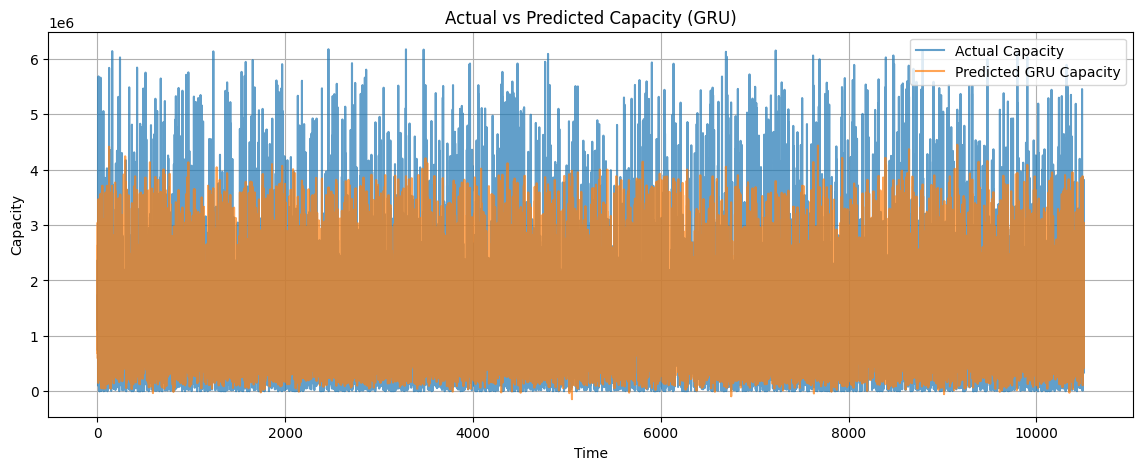

In [29]:
# Plot Predictions vs Actual Values for GRU
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_GRU_capacity, label='Predicted GRU Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (GRU)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

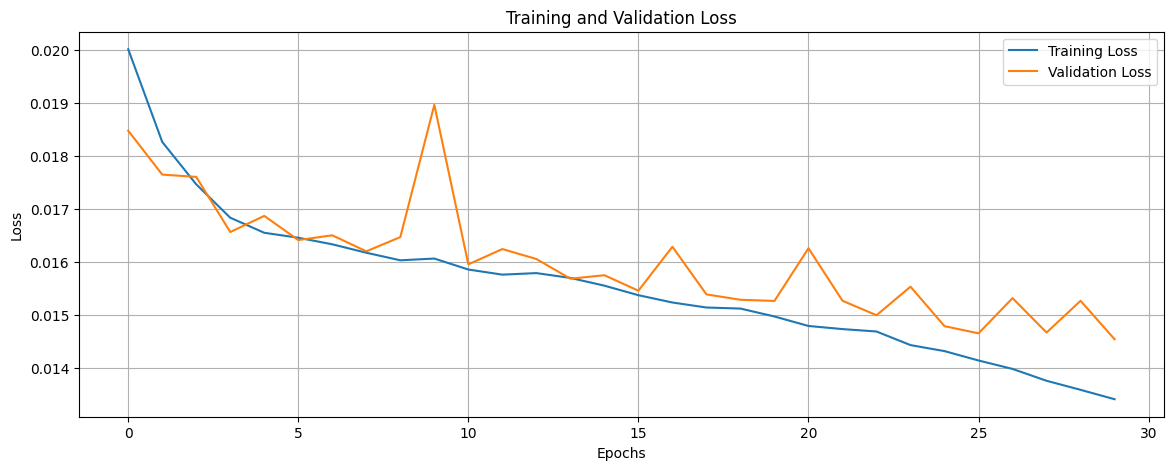

In [30]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(GRU_history.history['loss'], label='Training Loss')
plt.plot(GRU_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

LSTM Model RMSE: 752892.2284
RNN Model RMSE: 891268.2458
GRU Model RMSE: 734343.8819


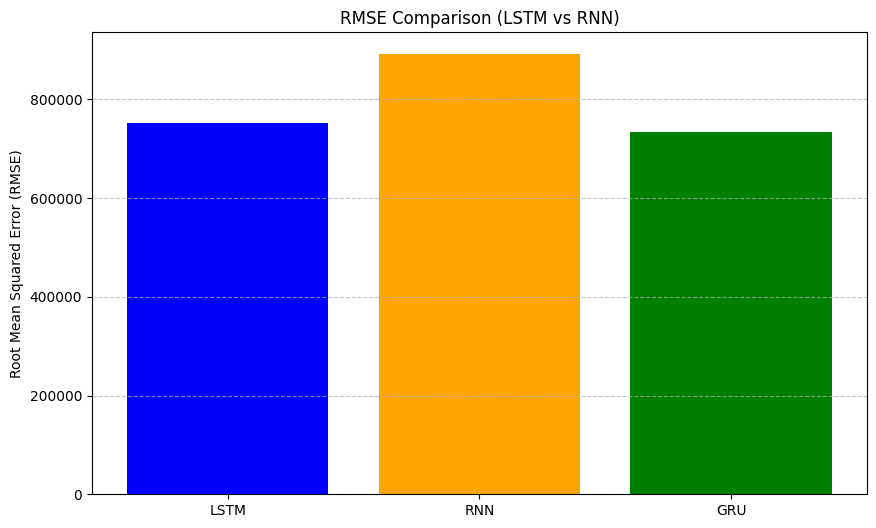

In [31]:
from sklearn.metrics import mean_squared_error
import numpy as np

# LSTM RMSE
lstm_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_capacity))
print(f'LSTM Model RMSE: {lstm_rmse:.4f}')

# RNN RMSE
rnn_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn_capacity))
print(f'RNN Model RMSE: {rnn_rmse:.4f}')

# GRU RMSE
GRU_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_GRU_capacity))
print(f'GRU Model RMSE: {GRU_rmse:.4f}')

# Create a bar plot
models = ['LSTM', 'RNN', 'GRU']
rmse_values = [lstm_rmse, rnn_rmse, GRU_rmse]

plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color=['blue', 'orange', 'green'])
plt.title('RMSE Comparison (LSTM vs RNN)')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

# MAE for LSTM and RNN
lstm_mae = mean_absolute_error(actual_capacity, predicted_capacity)
rnn_mae = mean_absolute_error(actual_capacity, predicted_rnn_capacity)
GRU_mae = mean_absolute_error(actual_capacity, predicted_GRU_capacity)

# R² Score for LSTM and RNN
lstm_r2 = r2_score(actual_capacity, predicted_capacity)
rnn_r2 = r2_score(actual_capacity, predicted_rnn_capacity)
GRU_r2 = r2_score(actual_capacity, predicted_GRU_capacity)

# Print additional metrics
print(f'LSTM Model MAE: {lstm_mae:.4f}')
print(f'RNN Model MAE: {rnn_mae:.4f}')
print(f'GRU Model MAE: {GRU_mae:.4f}')
print(f'LSTM Model R² Score: {lstm_r2:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'GRU Model R² Score: {GRU_r2:.4f}')


LSTM Model MAE: 533787.0883
RNN Model MAE: 614868.0141
GRU Model MAE: 526181.6914
LSTM Model R² Score: 0.6517
RNN Model R² Score: 0.5119
GRU Model R² Score: 0.6686


# building further on the rnn

In [33]:
from tensorflow.keras.layers import SimpleRNN, Dropout

rnn2_model = Sequential([
    SimpleRNN(128, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.3),
    SimpleRNN(64, return_sequences=True),
    Dropout(0.3),
    SimpleRNN(32),
    Dropout(0.3),
    Dense(1)
])

# Compile the model
rnn2_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn2_model.summary()


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 24, 128)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 24, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,513 (127.00 KB)

 Trainable params: 32,513 (127.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the RNN model
rnn2_history = rnn2_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

Epoch 1/30
1051/1051 - 6s - 5ms/step - loss: 0.0926 - mae: 0.2108 - val_loss: 0.0183 - val_mae: 0.0976
Epoch 2/30
1051/1051 - 5s - 4ms/step - loss: 0.0221 - mae: 0.1113 - val_loss: 0.0179 - val_mae: 0.0952
Epoch 3/30
1051/1051 - 5s - 4ms/step - loss: 0.0192 - mae: 0.1023 - val_loss: 0.0176 - val_mae: 0.0971
Epoch 4/30
1051/1051 - 5s - 4ms/step - loss: 0.0182 - mae: 0.0994 - val_loss: 0.0175 - val_mae: 0.0928
Epoch 5/30
1051/1051 - 5s - 4ms/step - loss: 0.0177 - mae: 0.0981 - val_loss: 0.0168 - val_mae: 0.0929
Epoch 6/30
1051/1051 - 5s - 4ms/step - loss: 0.0173 - mae: 0.0967 - val_loss: 0.0171 - val_mae: 0.0936
Epoch 7/30
1051/1051 - 5s - 4ms/step - loss: 0.0173 - mae: 0.0964 - val_loss: 0.0181 - val_mae: 0.0927
Epoch 8/30
1051/1051 - 5s - 4ms/step - loss: 0.0172 - mae: 0.0963 - val_loss: 0.0182 - val_mae: 0.0963
Epoch 9/30
1051/1051 - 5s - 4ms/step - loss: 0.0171 - mae: 0.0959 - val_loss: 0.0169 - val_mae: 0.0917
Epoch 10/30
1051/1051 - 5s - 4ms/step - loss: 0.0172 - mae: 0.0964 - val_

In [35]:
# Make predictions using the RNN model
rnn2_predictions = rnn2_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn2_capacity = target_scaler.inverse_transform(rnn2_predictions)

329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


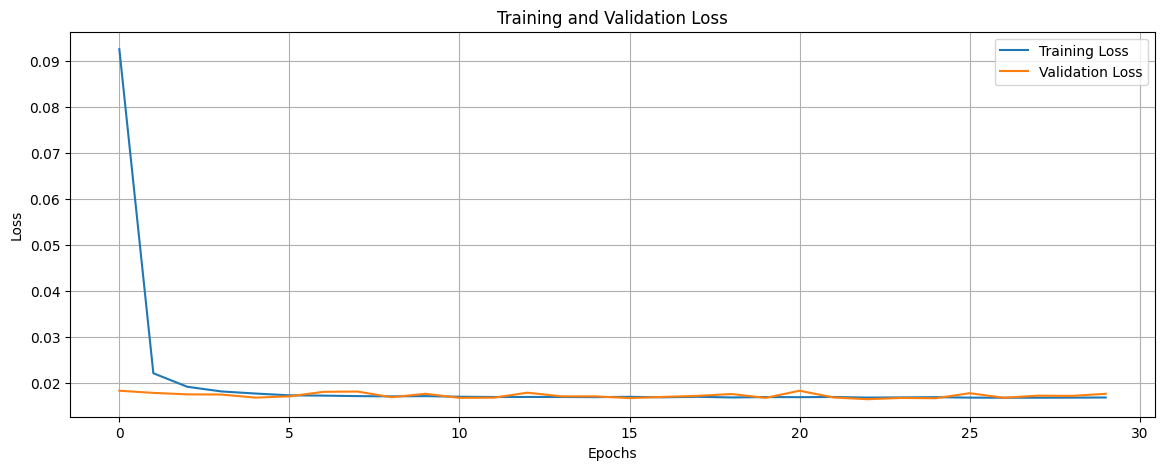

In [36]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn2_history.history['loss'], label='Training Loss')
plt.plot(rnn2_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

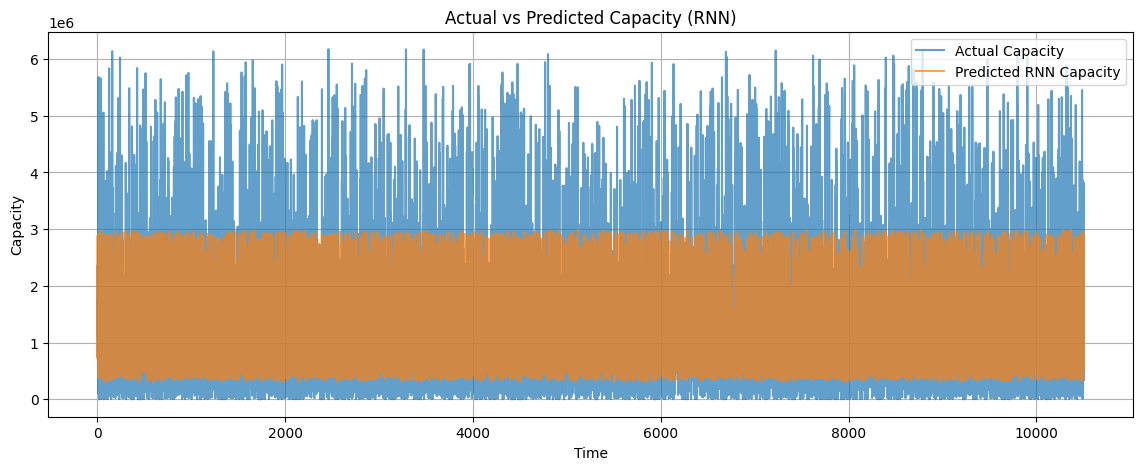

In [37]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn2_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()


In [38]:
rnn2_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn2_capacity))
r2_score_rnn2 = r2_score(actual_capacity, predicted_rnn2_capacity)
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')

RNN2 Model RMSE: 808613.2760
RNN2 Model R² Score: 0.5982


#### L2 

In [39]:
from tensorflow.keras.regularizers import l2

rnn3_model = Sequential([
    SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(0.01), input_shape=(seq_length, len(features))),
    Dropout(0.3),
    SimpleRNN(64, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1)
])


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
# Compile the model
rnn3_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn3_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 24, 128)        │        17,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,441 (115.00 KB)

 Trainable params: 29,441 (115.00 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the RNN model
rnn3_history = rnn3_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

Epoch 1/30
1051/1051 - 4s - 4ms/step - loss: 0.3416 - mae: 0.1550 - val_loss: 0.0523 - val_mae: 0.1039
Epoch 2/30
1051/1051 - 3s - 3ms/step - loss: 0.0328 - mae: 0.1049 - val_loss: 0.0242 - val_mae: 0.1036
Epoch 3/30
1051/1051 - 3s - 3ms/step - loss: 0.0239 - mae: 0.1051 - val_loss: 0.0240 - val_mae: 0.1010
Epoch 4/30
1051/1051 - 3s - 3ms/step - loss: 0.0234 - mae: 0.1054 - val_loss: 0.0222 - val_mae: 0.1019
Epoch 5/30
1051/1051 - 3s - 3ms/step - loss: 0.0229 - mae: 0.1043 - val_loss: 0.0229 - val_mae: 0.0984
Epoch 6/30
1051/1051 - 3s - 3ms/step - loss: 0.0229 - mae: 0.1046 - val_loss: 0.0239 - val_mae: 0.1176
Epoch 7/30
1051/1051 - 3s - 3ms/step - loss: 0.0226 - mae: 0.1040 - val_loss: 0.0241 - val_mae: 0.1100
Epoch 8/30
1051/1051 - 3s - 3ms/step - loss: 0.0226 - mae: 0.1046 - val_loss: 0.0232 - val_mae: 0.1004
Epoch 9/30
1051/1051 - 3s - 3ms/step - loss: 0.0223 - mae: 0.1036 - val_loss: 0.0231 - val_mae: 0.1128
Epoch 10/30
1051/1051 - 3s - 3ms/step - loss: 0.0224 - mae: 0.1040 - val_

In [42]:
# Make predictions using the RNN model
rnn3_predictions = rnn3_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn3_capacity = target_scaler.inverse_transform(rnn3_predictions)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


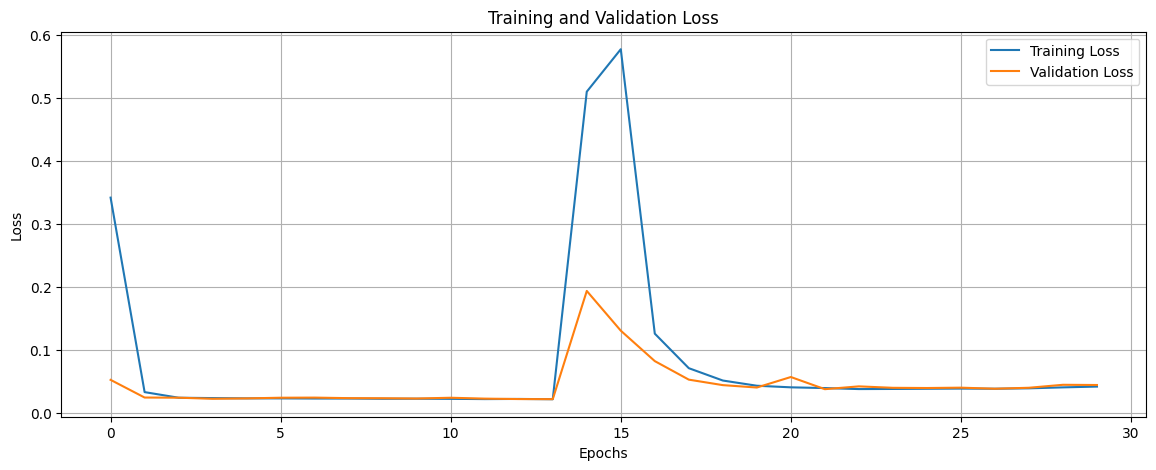

In [43]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn3_history.history['loss'], label='Training Loss')
plt.plot(rnn3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

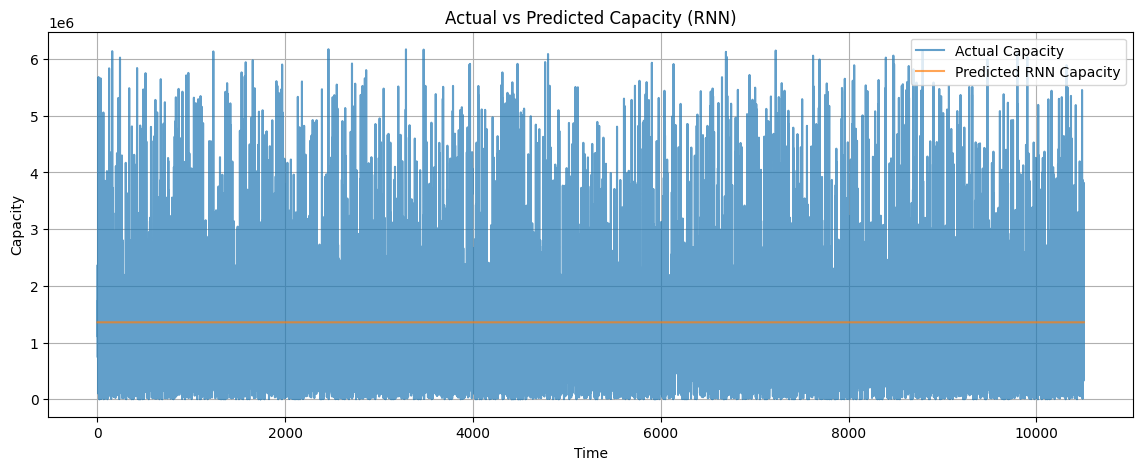

In [44]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn3_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
rnn3_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn3_capacity))
r2_score_rnn3 = r2_score(actual_capacity, predicted_rnn3_capacity)

print(f'RNN Model RMSE: {rnn_rmse:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')
print(f'RNN3 Model RMSE: {rnn3_rmse:.4f}')
print(f'RNN3 Model R² Score: {r2_score_rnn3:.4f}')


RNN Model RMSE: 891268.2458
RNN Model R² Score: 0.5119
RNN2 Model RMSE: 808613.2760
RNN2 Model R² Score: 0.5982
RNN3 Model RMSE: 1276752.4180
RNN3 Model R² Score: -0.0017


### reduce complexity 

In [46]:
rnn4_model = Sequential([
    SimpleRNN(64, return_sequences=True, input_shape=(seq_length, len(features))),
    Dropout(0.2),
    SimpleRNN(32),
    Dropout(0.2),
    Dense(1)
])

# Compile the model
rnn4_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print the summary of the RNN model
rnn4_model.summary()

c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_7 (SimpleRNN)        │ (None, 24, 64)         │         4,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 32)             │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,553 (29.50 KB)

 Non-trainable params: 0 (0.00 B)

In [47]:
# Train the RNN model
rnn4_history = rnn2_model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    verbose=2
)

Epoch 1/30
1051/1051 - 5s - 4ms/step - loss: 0.0168 - mae: 0.0950 - val_loss: 0.0167 - val_mae: 0.0917
Epoch 2/30
1051/1051 - 5s - 4ms/step - loss: 0.0168 - mae: 0.0950 - val_loss: 0.0171 - val_mae: 0.0935
Epoch 3/30
1051/1051 - 5s - 4ms/step - loss: 0.0168 - mae: 0.0949 - val_loss: 0.0173 - val_mae: 0.0952
Epoch 4/30
1051/1051 - 5s - 4ms/step - loss: 0.0169 - mae: 0.0952 - val_loss: 0.0165 - val_mae: 0.0911
Epoch 5/30
1051/1051 - 5s - 4ms/step - loss: 0.0169 - mae: 0.0952 - val_loss: 0.0168 - val_mae: 0.0929
Epoch 6/30
1051/1051 - 5s - 4ms/step - loss: 0.0167 - mae: 0.0947 - val_loss: 0.0166 - val_mae: 0.0936
Epoch 7/30
1051/1051 - 5s - 4ms/step - loss: 0.0168 - mae: 0.0953 - val_loss: 0.0165 - val_mae: 0.0930
Epoch 8/30
1051/1051 - 5s - 4ms/step - loss: 0.0167 - mae: 0.0946 - val_loss: 0.0169 - val_mae: 0.0914
Epoch 9/30
1051/1051 - 5s - 4ms/step - loss: 0.0167 - mae: 0.0948 - val_loss: 0.0168 - val_mae: 0.0909
Epoch 10/30
1051/1051 - 5s - 4ms/step - loss: 0.0168 - mae: 0.0948 - val_

In [48]:
# Make predictions using the RNN model
rnn4_predictions = rnn4_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn4_capacity = target_scaler.inverse_transform(rnn4_predictions)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step


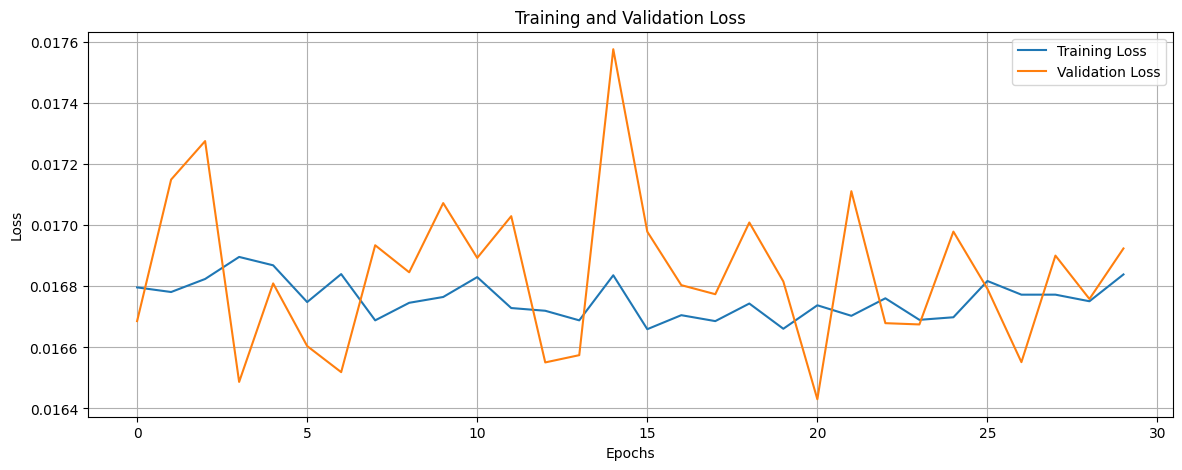

In [49]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn4_history.history['loss'], label='Training Loss')
plt.plot(rnn4_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

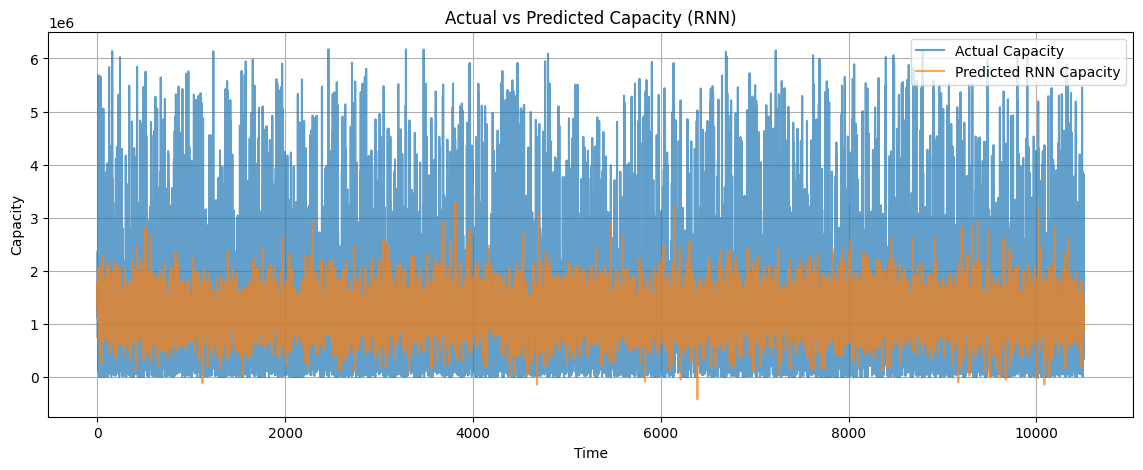

In [50]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn4_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
rnn4_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn4_capacity))
r2_score_rnn4 = r2_score(actual_capacity, predicted_rnn4_capacity)

print(f'RNN Model RMSE: {rnn_rmse:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')
print(f'RNN3 Model RMSE: {rnn3_rmse:.4f}')
print(f'RNN3 Model R² Score: {r2_score_rnn3:.4f}')
print(f'RNN4 Model RMSE: {rnn4_rmse:.4f}')
print(f'RNN4 Model R² Score: {r2_score_rnn4:.4f}')

RNN Model RMSE: 891268.2458
RNN Model R² Score: 0.5119
RNN2 Model RMSE: 808613.2760
RNN2 Model R² Score: 0.5982
RNN3 Model RMSE: 1276752.4180
RNN3 Model R² Score: -0.0017
RNN4 Model RMSE: 1289994.7304
RNN4 Model R² Score: -0.0226


### early stopping on the 3rd model 

In [52]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

rnn3_history = rnn3_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=3
)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100


In [53]:
# Make predictions using the RNN model
rnn3_predictions = rnn3_model.predict(X_test)

# Inverse transform the predictions
predicted_rnn3_capacity = target_scaler.inverse_transform(rnn3_predictions)

329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


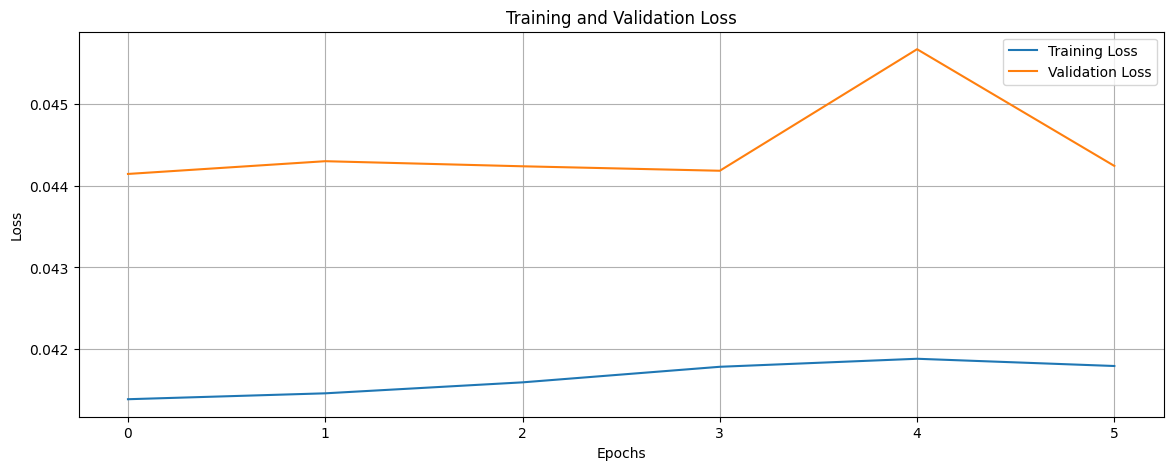

In [54]:
# Plot training history
plt.figure(figsize=(14, 5))
plt.plot(rnn3_history.history['loss'], label='Training Loss')
plt.plot(rnn3_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

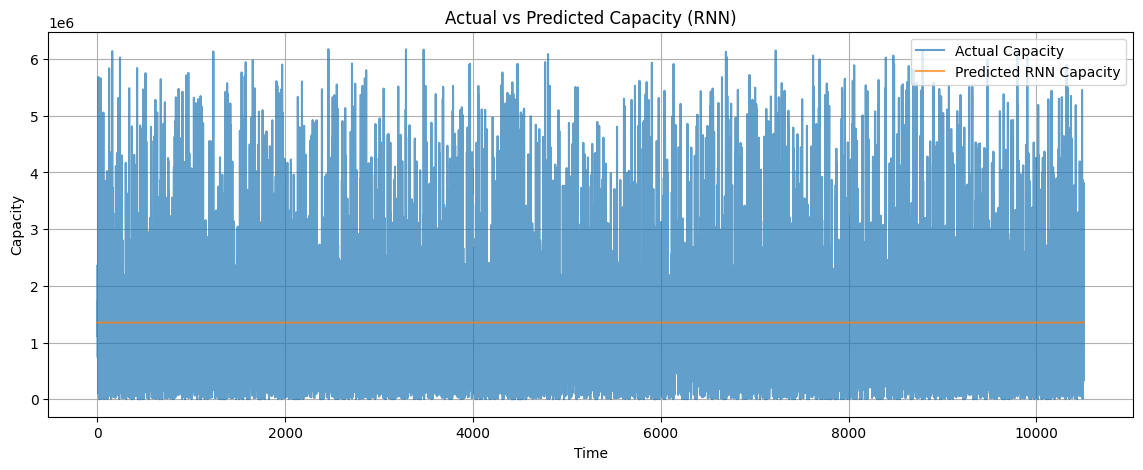

In [55]:
# Plot Predictions vs Actual Values for RNN
plt.figure(figsize=(14, 5))
plt.plot(actual_capacity, label='Actual Capacity', alpha=0.7)
plt.plot(predicted_rnn3_capacity, label='Predicted RNN Capacity', alpha=0.7)
plt.title('Actual vs Predicted Capacity (RNN)')
plt.xlabel('Time')
plt.ylabel('Capacity')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
rnn5_rmse = np.sqrt(mean_squared_error(actual_capacity, predicted_rnn3_capacity))
r2_score_rnn5 = r2_score(actual_capacity, predicted_rnn3_capacity)

print(f'RNN Model RMSE: {rnn_rmse:.4f}')
print(f'RNN Model R² Score: {rnn_r2:.4f}')
print(f'RNN2 Model RMSE: {rnn2_rmse:.4f}')
print(f'RNN2 Model R² Score: {r2_score_rnn2:.4f}')
print(f'RNN3 Model RMSE: {rnn3_rmse:.4f}')
print(f'RNN3 Model R² Score: {r2_score_rnn3:.4f}')
print(f'RNN4 Model RMSE: {rnn4_rmse:.4f}')
print(f'RNN5 Model R² Score: {r2_score_rnn5:.4f}')
print(f'RNN5 Model RMSE: {rnn5_rmse:.4f}')

RNN Model RMSE: 891268.2458
RNN Model R² Score: 0.5119
RNN2 Model RMSE: 808613.2760
RNN2 Model R² Score: 0.5982
RNN3 Model RMSE: 1276752.4180
RNN3 Model R² Score: -0.0017
RNN4 Model RMSE: 1289994.7304
RNN5 Model R² Score: -0.0014
RNN5 Model RMSE: 1276551.8665


In [57]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# TensorFlow imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam


# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Function to define the RNN model
def create_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(64, return_sequences=False, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# K-Fold Cross Validation Loop
fold_no = 1
for train_index, val_index in kf.split(X):
    print(f"Training fold {fold_no}...")

    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new model for each fold
    model = create_rnn_model()

    # Train the model
    model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=0)

    # Predict and calculate R²
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    
    print(f"Fold {fold_no} - R²: {r2:.4f}")
    fold_no += 1


Training fold 1...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step
Fold 1 - R²: 0.6333
Training fold 2...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
Fold 2 - R²: 0.6275
Training fold 3...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step
Fold 3 - R²: 0.6247
Training fold 4...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step
Fold 4 - R²: 0.6252
Training fold 5...


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step
Fold 5 - R²: 0.6233


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam

# Function to define the RNN model
def create_rnn_model():
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        SimpleRNN(64, return_sequences=False),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model


In [59]:
fold_no = 1
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new model for each fold
    model = create_rnn_model()

    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=64, verbose=0)

    # Predict and calculate R²
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    
    # Print results for each fold
    print(f"Fold {fold_no} - R²: {r2:.4f}")
    fold_no += 1


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step
Fold 1 - R²: 0.6594
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
Fold 2 - R²: 0.6284
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step
Fold 3 - R²: 0.6458
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step
Fold 4 - R²: 0.6423
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step
Fold 5 - R²: 0.6347


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Function to define the RNN model
def create_rnn_model():
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        SimpleRNN(64, return_sequences=True),  # First RNN layer
        SimpleRNN(32, return_sequences=False),  # Second RNN layer
        Dense(32, activation='relu'),  # Hidden dense layer
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# K-Fold Cross Validation Loop
fold_no = 1
for train_index, val_index in kf.split(X):
    # Split data
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create a new model for each fold
    model = create_rnn_model()

    # Train the model with early stopping
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100, batch_size=64, verbose=0,
        callbacks=[early_stopping]
    )

    # Predict and calculate R²
    y_pred = model.predict(X_val).flatten()
    r2 = r2_score(y_val, y_pred)
    
    # Print results for each fold
    print(f"Fold {fold_no} - R²: {r2:.4f}")
    fold_no += 1


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Fold 1 - R²: 0.6616
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 - R²: 0.6260
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 - R²: 0.6125
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step
Fold 4 - R²: 0.6249
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
Fold 5 - R²: 0.6126


In [61]:
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# # Function to create RNN model
# def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
#     model = Sequential()
#     model.add(SimpleRNN(units, return_sequences=layers > 1, input_shape=(X.shape[1], X.shape[2])))
    
#     for _ in range(layers - 1):
#         model.add(SimpleRNN(units, return_sequences=False))
#         model.add(Dropout(dropout_rate))
    
#     model.add(Dense(1))
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#     return model

# # List of hyperparameters to search
# param_grid = {
#     'units': [32, 64, 128],
#     'layers': [1, 2, 3],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'batch_size': [32, 64],
#     'epochs': [50, 100],
#     'learning_rate': [0.001, 0.0005],
# }

# # Initialize K-Fold
# kf = KFold(n_splits=5, shuffle=True, random_state=42)

# # Manual grid search loop
# best_score = -np.inf
# best_params = None

# for units in param_grid['units']:
#     for layers in param_grid['layers']:
#         for dropout_rate in param_grid['dropout_rate']:
#             for batch_size in param_grid['batch_size']:
#                 for epochs in param_grid['epochs']:
#                     for learning_rate in param_grid['learning_rate']:
#                         print(f"Training with units={units}, layers={layers}, dropout_rate={dropout_rate}, "
#                               f"batch_size={batch_size}, epochs={epochs}, learning_rate={learning_rate}")
                        
#                         # Initialize model
#                         model = create_rnn_model(units, layers, dropout_rate, learning_rate)
                        
#                         fold_scores = []
#                         for train_index, val_index in kf.split(X):
#                             # Split data
#                             X_train, X_val = X[train_index], X[val_index]
#                             y_train, y_val = y[train_index], y[val_index]
                            
#                             # Train model
#                             model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
                            
#                             # Predict and evaluate
#                             y_pred = model.predict(X_val).squeeze()
#                             fold_r2 = r2_score(y_val, y_pred)
#                             fold_scores.append(fold_r2)
                        
#                         mean_score = np.mean(fold_scores)
#                         print(f"Mean R² for this configuration: {mean_score:.4f}")
                        
#                         # Check if this is the best model
#                         if mean_score > best_score:
#                             best_score = mean_score
#                             best_params = {
#                                 'units': units,
#                                 'layers': layers,
#                                 'dropout_rate': dropout_rate,
#                                 'batch_size': batch_size,
#                                 'epochs': epochs,
#                                 'learning_rate': learning_rate,
#                             }

# print("\nBest R² Score: {:.4f}".format(best_score))
# print("Best Hyperparameters:", best_params)


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Function to create RNN model with parameters
def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # First RNN layer
    model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(X.shape[1], X.shape[2])))
    
    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# List of hyperparameters to search
param_grid = {
    'units': [64, 128, 256],
    'layers': [3, 4, 5],
    'dropout_rate': [0.2, 0.3, 0.4],
    'batch_size': [64, 128],
    'learning_rate': [0.1, 0.2],
}

# Initialize K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Manual grid search loop
best_score = -np.inf
best_params = None

for units in param_grid['units']:
    for layers in param_grid['layers']:
        for dropout_rate in param_grid['dropout_rate']:
            for batch_size in param_grid['batch_size']:
                for learning_rate in param_grid['learning_rate']:
                        print(f"Training with units={units}, layers={layers}, dropout_rate={dropout_rate}, "
                              f"batch_size={batch_size},learning_rate={learning_rate}")
                        
                        # Initialize model
                        model = create_rnn_model(units, layers, dropout_rate, learning_rate)

                        # Early stopping callback
                        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

                        fold_scores = []
                        for train_index, val_index in kf.split(X):
                            # Split data
                            X_train, X_val = X[train_index], X[val_index]
                            y_train, y_val = y[train_index], y[val_index]
                            
                            # Train model with early stopping
                            model.fit(X_train, y_train, epochs=30, batch_size=batch_size, 
                                      validation_data=(X_val, y_val), verbose=0, callbacks=[early_stopping])
                            
                            # Predict and evaluate
                            y_pred = model.predict(X_val).squeeze()
                            fold_r2 = r2_score(y_val, y_pred)
                            fold_scores.append(fold_r2)
                        
                        mean_score = np.mean(fold_scores)
                        print(f"Mean R² for this configuration: {mean_score:.4f}")
                        
                        # Check if this is the best model
                        if mean_score > best_score:
                            best_score = mean_score
                            best_params = {
                                'units': units,
                                'layers': layers,
                                'dropout_rate': dropout_rate,
                                'batch_size': batch_size,
                                'learning_rate': learning_rate,
                            }

# Print the best results
print("\nBest R² Score: {:.4f}".format(best_score))
print("Best Hyperparameters:", best_params)


Training with units=64, layers=3, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.0985
Training with units=64, layers=3, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.1689
Training with units=64, layers=3, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: 0.0169
Training with units=64, layers=3, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.0314
Training with units=64, layers=3, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: 0.0108
Training with units=64, layers=3, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.1003
Training with units=64, layers=3, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.0066
Training with units=64, layers=3, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: 0.0313
Training with units=64, layers=3, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.1039
Training with units=64, layers=3, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.1666
Training with units=64, layers=3, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.0049
Training with units=64, layers=3, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean R² for this configuration: -0.1788
Training with units=64, layers=4, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0371
Training with units=64, layers=4, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.1684
Training with units=64, layers=4, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0126
Training with units=64, layers=4, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0475
Training with units=64, layers=4, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0147
Training with units=64, layers=4, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0403
Training with units=64, layers=4, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0165
Training with units=64, layers=4, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0605
Training with units=64, layers=4, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0102
Training with units=64, layers=4, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0020
Training with units=64, layers=4, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0662
Training with units=64, layers=4, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0552
Training with units=64, layers=5, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0365
Training with units=64, layers=5, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0352
Training with units=64, layers=5, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0157
Training with units=64, layers=5, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0258
Training with units=64, layers=5, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0424
Training with units=64, layers=5, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0800
Training with units=64, layers=5, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0451
Training with units=64, layers=5, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0079
Training with units=64, layers=5, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0161
Training with units=64, layers=5, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0078
Training with units=64, layers=5, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0619
Training with units=64, layers=5, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0353
Training with units=128, layers=3, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0427
Training with units=128, layers=3, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.2680
Training with units=128, layers=3, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0327
Training with units=128, layers=3, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0105
Training with units=128, layers=3, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.1024
Training with units=128, layers=3, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0175
Training with units=128, layers=3, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0251
Training with units=128, layers=3, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0938
Training with units=128, layers=3, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0838
Training with units=128, layers=3, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0143
Training with units=128, layers=3, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0460
Training with units=128, layers=3, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0631
Training with units=128, layers=4, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean R² for this configuration: -0.0290
Training with units=128, layers=4, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean R² for this configuration: -0.0339
Training with units=128, layers=4, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean R² for this configuration: 0.1009
Training with units=128, layers=4, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0737
Training with units=128, layers=4, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0503
Training with units=128, layers=4, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0302
Training with units=128, layers=4, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0023
Training with units=128, layers=4, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0719
Training with units=128, layers=4, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.1254
Training with units=128, layers=4, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0048
Training with units=128, layers=4, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean R² for this configuration: -0.0043
Training with units=128, layers=4, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean R² for this configuration: -0.0980
Training with units=128, layers=5, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0513
Training with units=128, layers=5, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.3938
Training with units=128, layers=5, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: 0.0211
Training with units=128, layers=5, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: -0.0374
Training with units=128, layers=5, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0074
Training with units=128, layers=5, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0712
Training with units=128, layers=5, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0463
Training with units=128, layers=5, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0291
Training with units=128, layers=5, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0781
Training with units=128, layers=5, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Mean R² for this configuration: -0.0445
Training with units=128, layers=5, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: -0.1123
Training with units=128, layers=5, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: -0.0711
Training with units=256, layers=3, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: -0.2266
Training with units=256, layers=3, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean R² for this configuration: -1.1061
Training with units=256, layers=3, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean R² for this configuration: -0.0051
Training with units=256, layers=3, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean R² for this configuration: 0.0269
Training with units=256, layers=3, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean R² for this configuration: -0.1145
Training with units=256, layers=3, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean R² for this configuration: -0.4339
Training with units=256, layers=3, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: 0.0219
Training with units=256, layers=3, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: -0.1130
Training with units=256, layers=3, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Mean R² for this configuration: -0.0564
Training with units=256, layers=3, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Mean R² for this configuration: -0.1852
Training with units=256, layers=3, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean R² for this configuration: -0.0533
Training with units=256, layers=3, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean R² for this configuration: -0.0599
Training with units=256, layers=4, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Mean R² for this configuration: -0.2750
Training with units=256, layers=4, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Mean R² for this configuration: 0.0159
Training with units=256, layers=4, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
Mean R² for this configuration: -0.0039
Training with units=256, layers=4, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Mean R² for this configuration: -0.2647
Training with units=256, layers=4, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
Mean R² for this configuration: -0.0529
Training with units=256, layers=4, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Mean R² for this configuration: -0.1625
Training with units=256, layers=4, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
Mean R² for this configuration: -0.0362
Training with units=256, layers=4, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
Mean R² for this configuration: -0.1614
Training with units=256, layers=4, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Mean R² for this configuration: -0.1720
Training with units=256, layers=4, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Mean R² for this configuration: -0.1389
Training with units=256, layers=4, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Mean R² for this configuration: -0.2320
Training with units=256, layers=4, dropout_rate=0.4, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
Mean R² for this configuration: -0.2110
Training with units=256, layers=5, dropout_rate=0.2, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Mean R² for this configuration: -0.0741
Training with units=256, layers=5, dropout_rate=0.2, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Mean R² for this configuration: -0.2048
Training with units=256, layers=5, dropout_rate=0.2, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
Mean R² for this configuration: -0.1035
Training with units=256, layers=5, dropout_rate=0.2, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step
Mean R² for this configuration: -0.4345
Training with units=256, layers=5, dropout_rate=0.3, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step
Mean R² for this configuration: -0.0826
Training with units=256, layers=5, dropout_rate=0.3, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Mean R² for this configuration: -0.8394
Training with units=256, layers=5, dropout_rate=0.3, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step
Mean R² for this configuration: -0.0265
Training with units=256, layers=5, dropout_rate=0.3, batch_size=128,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step
Mean R² for this configuration: -0.0759
Training with units=256, layers=5, dropout_rate=0.4, batch_size=64,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
Mean R² for this configuration: -0.1377
Training with units=256, layers=5, dropout_rate=0.4, batch_size=64,learning_rate=0.2


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step
Mean R² for this configuration: -0.5833
Training with units=256, layers=5, dropout_rate=0.4, batch_size=128,learning_rate=0.1


c:\Users\Marjolein\Documents\GitHub\EnergieOpwek\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step


In [70]:
# import numpy as np
# from sklearn.model_selection import KFold
# from sklearn.metrics import r2_score
# from sklearn.preprocessing import StandardScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping

# # Function to create RNN model with parameters
# def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
#     model = Sequential()
#     # First RNN layer
#     model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))

#     # Additional RNN layers with Dropout
#     for i in range(1, layers):
#         model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
#         model.add(Dropout(dropout_rate))

#     # Output layer
#     model.add(Dense(1))

#     # Compile the model
#     model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
#     return model

# # List of hyperparameters to search
# param_grid = {
#     'units': [64, 128, 256],
#     'layers': [3, 4, 5],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'batch_size': [64, 128],
#     'learning_rate': [0.1, 0.2],
# }

# # Initialize K-Fold cross-validation on the training set
# kf = KFold(n_splits=3, shuffle=True, random_state=42)

# # Manual grid search loop
# best_score = -np.inf
# best_params = None

# for units in param_grid['units']:
#     for layers in param_grid['layers']:
#         for dropout_rate in param_grid['dropout_rate']:
#             for batch_size in param_grid['batch_size']:
#                 for learning_rate in param_grid['learning_rate']:
#                     print(f"Training with units={units}, layers={layers}, dropout_rate={dropout_rate}, "
#                           f"batch_size={batch_size}, learning_rate={learning_rate}")

#                     # Initialize model
#                     model = create_rnn_model(units, layers, dropout_rate, learning_rate)

#                     # Early stopping callback
#                     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#                     fold_scores = []
#                     for train_index, val_index in kf.split(X_train):
#                         # Split data
#                         X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
#                         y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

#                         # Train model with early stopping
#                         model.fit(X_fold_train, y_fold_train, epochs=30, batch_size=batch_size,
#                                   validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

#                         # Predict and evaluate on validation fold
#                         y_pred = model.predict(X_fold_val).squeeze()
#                         fold_r2 = r2_score(y_fold_val, y_pred)
#                         fold_scores.append(fold_r2)

#                     mean_score = np.mean(fold_scores)
#                     print(f"Mean R² for this configuration: {mean_score:.4f}")

#                     # Check if this is the best model
#                     if mean_score > best_score:
#                         best_score = mean_score
#                         best_params = {
#                             'units': units,
#                             'layers': layers,
#                             'dropout_rate': dropout_rate,
#                             'batch_size': batch_size,
#                             'learning_rate': learning_rate,
#                         }

# # Print the best results
# print("\nBest R² Score on validation folds: {:.4f}".format(best_score))
# print("Best Hyperparameters:", best_params)

# # Evaluate the best model on the test set
# print("\nEvaluating the best model on the test set...")

# # Train the best model on the entire training set
# final_model = create_rnn_model(**best_params)
# final_model.fit(X_train, y_train, epochs=30, batch_size=best_params['batch_size'], verbose=0)

# # Predict on the test set
# y_test_pred = final_model.predict(X_test).squeeze()
# test_r2 = r2_score(y_test, y_test_pred)

# print(f"Final R² Score on the test set: {test_r2:.4f}")



import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna

# Function to create RNN model with parameters
def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # First RNN layer
    model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))

    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize K-Fold cross-validation on the training set
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    units = trial.suggest_categorical('units', [64, 128, 256])
    layers = trial.suggest_int('layers', 1, 5)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])

    # Create the model with the suggested hyperparameters
    model = create_rnn_model(units, layers, dropout_rate, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    fold_scores = []
    for train_index, val_index in kf.split(np.arange(len(X_train))):
        # Split data
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Train model with early stopping
        model.fit(X_fold_train, y_fold_train, epochs=30, batch_size=batch_size,
                  validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

        # Predict and evaluate on validation fold
        y_pred = model.predict(X_fold_val).squeeze()
        fold_r2 = r2_score(y_fold_val, y_pred)
        fold_scores.append(fold_r2)

    # Return the mean R² score for this trial
    return np.mean(fold_scores)

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best results
print("\nBest Hyperparameters:", study.best_params)

# Train the best model on the entire training set with the best hyperparameters
best_params = study.best_params
final_model = create_rnn_model(**best_params)
final_model.fit(X_train, y_train, epochs=30, batch_size=best_params['batch_size'], verbose=0)

# Predict on the test set
y_test_pred = final_model.predict(X_test).squeeze()
test_r2 = r2_score(y_test, y_test_pred)

# Print final evaluation
print(f"\nFinal R² Score on the test set: {test_r2:.4f}")


Training with units=64, layers=3, dropout_rate=0.2, batch_size=64, learning_rate=0.1


c:\Users\Marjolein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean R² for this configuration: -0.0917
Training with units=64, layers=3, dropout_rate=0.2, batch_size=64, learning_rate=0.2


c:\Users\Marjolein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean R² for this configuration: -0.0762
Training with units=64, layers=3, dropout_rate=0.2, batch_size=128, learning_rate=0.1


c:\Users\Marjolein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Mean R² for this configuration: -0.3290
Training with units=64, layers=3, dropout_rate=0.2, batch_size=128, learning_rate=0.2


c:\Users\Marjolein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: -0.0500
Training with units=64, layers=3, dropout_rate=0.3, batch_size=64, learning_rate=0.1


c:\Users\Marjolein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean R² for this configuration: 0.0516
Training with units=64, layers=3, dropout_rate=0.3, batch_size=64, learning_rate=0.2


c:\Users\Marjolein\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import optuna

# Function to create RNN model with parameters
def create_rnn_model(units=64, layers=1, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    # First RNN layer
    model.add(SimpleRNN(units, return_sequences=(layers > 1), input_shape=(X_train.shape[1], X_train.shape[2])))

    # Additional RNN layers with Dropout
    for i in range(1, layers):
        model.add(SimpleRNN(units, return_sequences=(i < layers - 1)))
        model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')
    return model

# Initialize K-Fold cross-validation on the training set
kf = KFold(n_splits=2, shuffle=True, random_state=42)  # Reduced to 2 splits to speed up

# Define the objective function for Optuna optimization
def objective(trial):
    # Suggest hyperparameters to optimize
    units = trial.suggest_categorical('units', [64, 128])  # Reduced options to speed up
    layers = trial.suggest_int('layers', 1, 3)  # Reduced max layers
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)  # Narrowed range
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-3)  # Narrowed range
    batch_size = trial.suggest_categorical('batch_size', [32, 64])  # Reduced options

    # Create the model with the suggested hyperparameters
    model = create_rnn_model(units, layers, dropout_rate, learning_rate)

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience

    fold_scores = []
    for train_index, val_index in kf.split(np.arange(len(X_train))):
        # Split data
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        # Train model with early stopping
        model.fit(X_fold_train, y_fold_train, epochs=15, batch_size=batch_size,  # Reduced epochs
                  validation_data=(X_fold_val, y_fold_val), verbose=0, callbacks=[early_stopping])

        # Predict and evaluate on validation fold
        y_pred = model.predict(X_fold_val).squeeze()
        fold_r2 = r2_score(y_fold_val, y_pred)
        fold_scores.append(fold_r2)

    # Return the mean R² score for this trial
    return np.mean(fold_scores)

# Create a study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Reduced number of trials

# Print the best results
print("\nBest Hyperparameters:", study.best_params)

# Train the best model on the entire training set with the best hyperparameters
best_params = study.best_params
final_model = create_rnn_model(**best_params)
final_model.fit(X_train, y_train, epochs=15, batch_size=best_params['batch_size'], verbose=0)  # Reduced epochs

# Predict on the test set
y_test_pred = final_model.predict(X_test).squeeze()
test_r2 = r2_score(y_test, y_test_pred)

# Print final evaluation
print(f"\nFinal R² Score on the test set: {test_r2:.4f}")
